<a href="https://colab.research.google.com/github/SLVmain/Neural_Network_start/blob/Les_08/HW_08_cifar10_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN  `Model.train_step`

(https://twitter.com/fchollet)


## Загрузка модулей

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

tf.config.experimental.set_visible_devices([], 'GPU')

## строим GAN на cifar10 

In [74]:

class_ = 3
batch_size = 64
(x_train, y), (x_test, yt) = keras.datasets.cifar10.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
ind_i = np.where(y == class_)
ind_it = np.where(yt == class_)
all_digits = all_digits[ind_i,:,:]
all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

## Строим discriminator

размер карты 28x28 и бинарная классификация (настоящее изображение или генерировано).

In [75]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=all_digits.shape[1:]), 
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)


discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 global_max_pooling2d_2 (Glo  (None, 128)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                     

## Строим generator

обратное по отношению к дискриминатору преобразование, меняем `Conv2D` на `Conv2DTranspose` .

In [76]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        
        layers.Dense(4 * 4 * 256),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(4, 4), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), padding="same", activation="tanh"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 4096)              266240    
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_16 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 8, 8, 256)        1048832   
 Transpose)                                                      
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 32, 32, 256)      1048832   
 Transpose)                                              

## Класс со своим этапом обучения `train_step`

In [12]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


## Callback для сохранения изображений по ходу обучения

In [13]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


## Учим end-to-end модель

In [77]:
epochs = 50

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/50
157/157 [==============================] - 5s 25ms/step - d_loss: 0.6206 - g_loss: 0.9532
Epoch 2/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.4589 - g_loss: 1.5028
Epoch 3/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.6608 - g_loss: 0.8927
Epoch 4/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.6279 - g_loss: 1.0204
Epoch 5/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.6812 - g_loss: 0.8671
Epoch 6/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.6706 - g_loss: 0.8870
Epoch 7/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.6482 - g_loss: 0.9445
Epoch 8/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.6919 - g_loss: 0.8383
Epoch 9/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.6803 - g_loss: 0.9333
Epoch 10/50
157/157 [==============================] - 4s 25ms/step - d_loss: 0.7081 - g_lo

Display the last generated images:

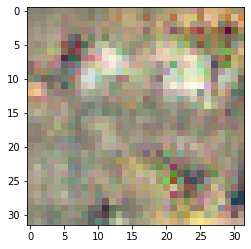

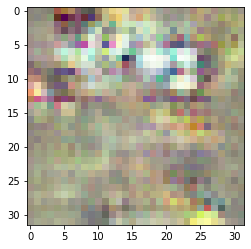

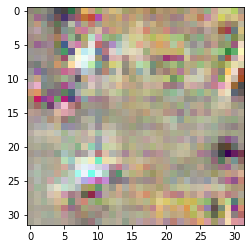

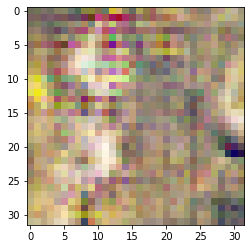

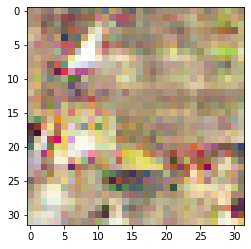

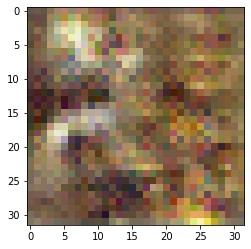

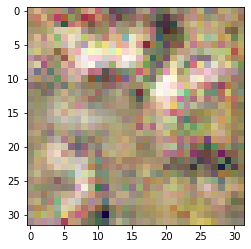

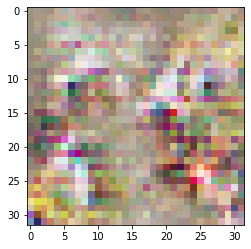

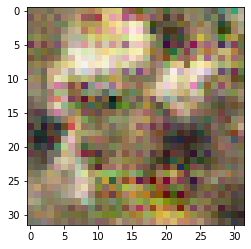

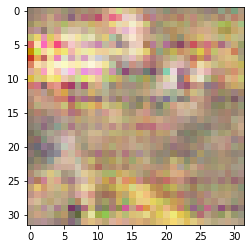

In [78]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
i = 2
#generated_img_{i}_{epoch}.png
for e_ in range (40,50):
  plt.imshow(image.load_img("generated_img_"+str(i)+"_" + str(e_)+".png").convert('RGBA'))
  plt.show()

In [ ]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

In [ ]:
for e_ in range (40,50):
  plt.imshow(image.load_img("generated_img_"+str(i)+"_" + str(e_)+".png").convert('RGBA'))
  plt.show()